<a href="https://colab.research.google.com/github/ssarker21/Introduction-to-Machine-Learning/blob/main/Homework_7(Problem_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu

Epoch=1 
Training Loss: 1.4815, Training Accuracy: 0.4667
Validation Loss: 1.2569, Validation Accuracy: 0.5520

Epoch=2 
Training Loss: 1.1703, Training Accuracy: 0.5865
Validation Loss: 1.1055, Validation Accuracy: 0.6111

Epoch=3 
Training Loss: 1.0460, Training Accuracy: 0.6306
Validation Loss: 1.0633, Validation Accuracy: 0.6223

Epoch=4 
Training Loss: 0.9643, Training Accuracy: 0.6604
Validation Loss: 1.0322, Validation Accuracy: 0.6351

Epoch=5 
Training Loss: 0.8982, Training Accuracy: 0.6856
Validation Loss: 0.9966, Validation Accuracy: 0.6479

Epoch=6 
Training Loss: 0.8425, Training Accuracy: 0.7058
Validation Loss: 1.0061, Validation Accuracy: 0.6497

Epoch=7 
Training Loss: 0.7949, Training Accuracy: 0.7196
Validation Loss: 0.9908, Validation Accuracy: 0.6607

Epoch=8 
Training Loss: 0.7495, Training Accuracy: 0.7362
Validation Loss: 0.9845, Validation Accuracy: 0.6602

Epoch=9 
Training Loss: 0.7062, Training Accuracy: 0.7506
Validation Loss: 1.0020, Validati

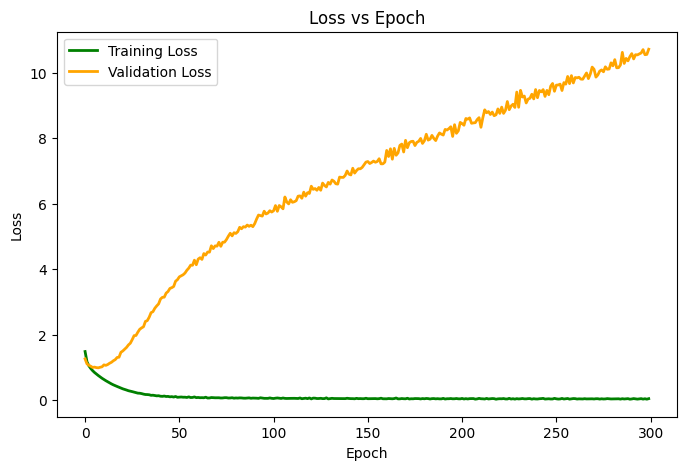

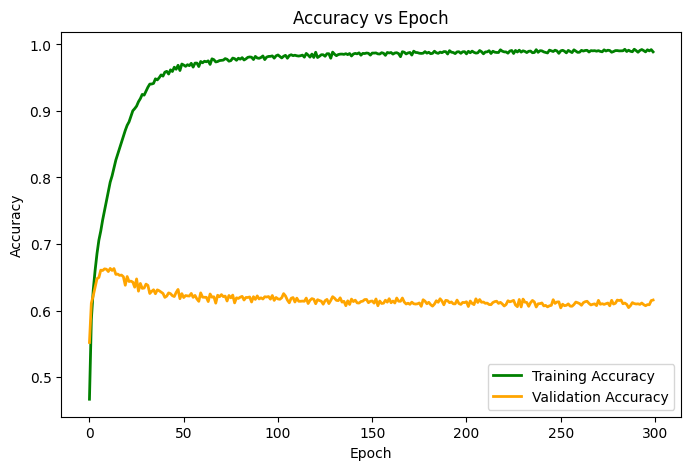

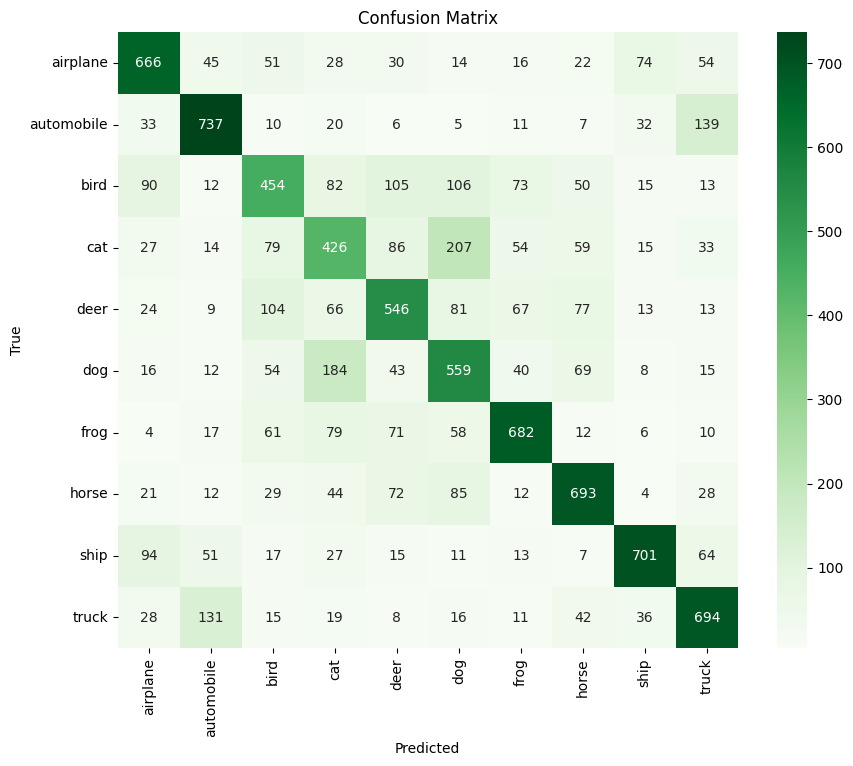

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=64, shuffle=False, num_workers=2)

classes = trainset.classes

# CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


# Storing data
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 300
start_time = time.time()

# Training loop
for epoch in range(num_epochs):

    # Training
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += y.size(0)
        correct_train += (predicted == y).sum().item()

    avg_train_loss = running_loss / len(trainloader)
    train_acc = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    # Validation
    net.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for x, y in valloader:
            x, y = x.to(device), y.to(device)

            outputs = net(x)
            loss = criterion(outputs, y)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += y.size(0)
            correct_val += (predicted == y).sum().item()

    avg_val_loss = running_val_loss / len(valloader)
    val_acc = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"\nEpoch={epoch+1} "
          f"\nTraining Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}"
          f"\nValidation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds\n")

# Model Size
def model_summary(model):
    print("\nModel Size\n")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"{name:20} --> {num_params} parameters")
    print(f"Total Trainable Parameters: {total_params:,}")
    print("\n")

model_summary(net)
# Plot (losses)
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss", linewidth=2, color="Green")
plt.plot(val_losses, label="Validation Loss", linewidth=2, color="Orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

# Plot (accuracies)
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Training Accuracy", linewidth=2, color="Green")
plt.plot(val_accs, label="Validation Accuracy", linewidth=2, color="Orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

# Confusion Matrix
all_preds = []
all_labels = []

net.eval()
with torch.no_grad():
    for x, y in valloader:
        x = x.to(device)
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Device: cpu

Epoch=1 
Training Loss: 1.5335, Training Accuracy: 0.4453
Validation Loss: 1.3048, Validation Accuracy: 0.5334

Epoch=2 
Training Loss: 1.2124, Training Accuracy: 0.5695
Validation Loss: 1.1329, Validation Accuracy: 0.6021

Epoch=3 
Training Loss: 1.0766, Training Accuracy: 0.6213
Validation Loss: 1.0628, Validation Accuracy: 0.6224

Epoch=4 
Training Loss: 0.9848, Training Accuracy: 0.6536
Validation Loss: 0.9961, Validation Accuracy: 0.6469

Epoch=5 
Training Loss: 0.9116, Training Accuracy: 0.6792
Validation Loss: 0.9845, Validation Accuracy: 0.6527

Epoch=6 
Training Loss: 0.8639, Training Accuracy: 0.6953
Validation Loss: 0.9314, Validation Accuracy: 0.6763

Epoch=7 
Training Loss: 0.8184, Training Accuracy: 0.7143
Validation Loss: 0.9325, Validation Accuracy: 0.6704

Epoch=8 
Training Loss: 0.7766, Training Accuracy: 0.7278
Validation Loss: 0.8963, Validation Accuracy: 0.6877

Epoch=9 
Training Loss: 0.7405, Training Accuracy: 0.7391
Validation Loss: 0.8663, Validati

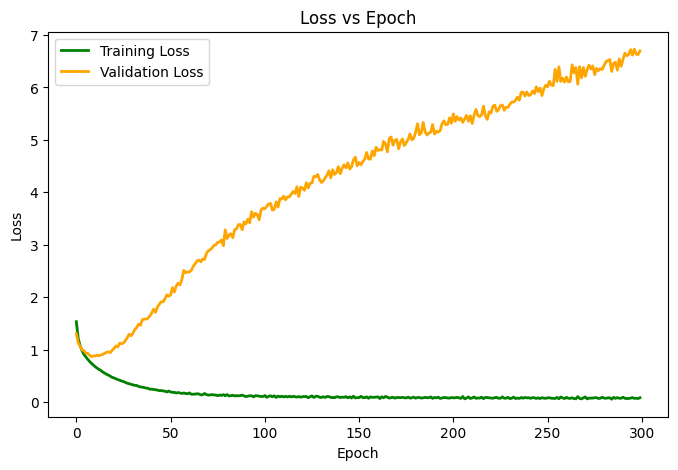

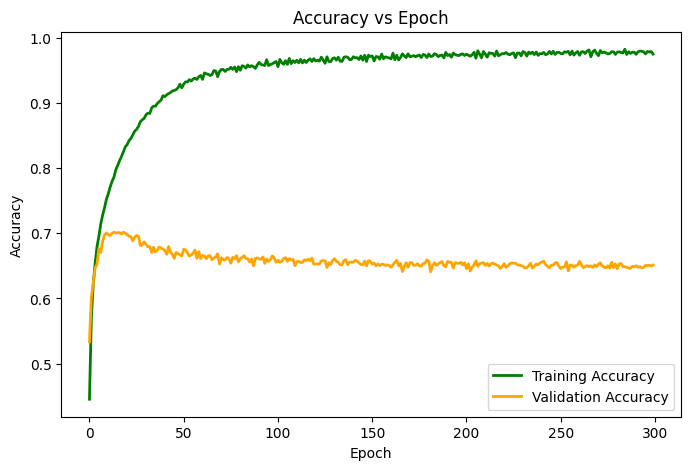

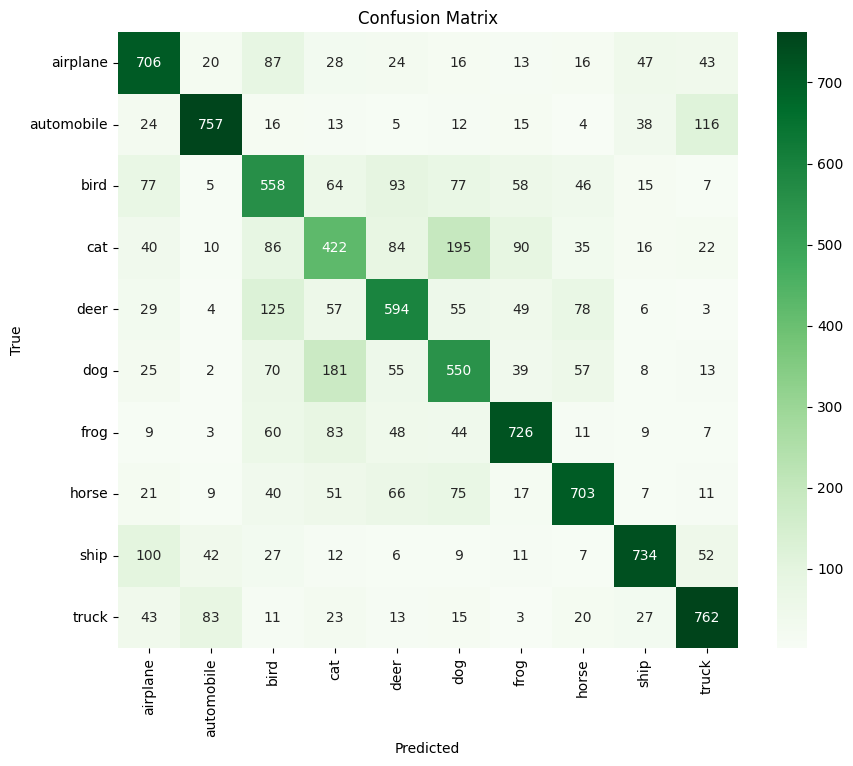

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=64, shuffle=False, num_workers=2)

classes = trainset.classes

# CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)    # output: 8x32x32
        self.pool1 = nn.MaxPool2d(2, 2)               # output: 8x16x16

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)   # output: 16x16x16
        self.pool2 = nn.MaxPool2d(2, 2)               # output: 16x8x8

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)  # NEW LAYER, output: 32x8x8
        self.pool3 = nn.MaxPool2d(2, 2)               # output: 32x4x4

        # Adjust FC layer: 32*4*4 = 512
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))   # NEW STAGE

        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


# Storing data
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 300
start_time = time.time()

# Training loop
for epoch in range(num_epochs):

    # Training
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += y.size(0)
        correct_train += (predicted == y).sum().item()

    avg_train_loss = running_loss / len(trainloader)
    train_acc = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    # Validation
    net.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for x, y in valloader:
            x, y = x.to(device), y.to(device)

            outputs = net(x)
            loss = criterion(outputs, y)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += y.size(0)
            correct_val += (predicted == y).sum().item()

    avg_val_loss = running_val_loss / len(valloader)
    val_acc = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"\nEpoch={epoch+1} "
          f"\nTraining Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}"
          f"\nValidation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds\n")

# Model Size
def model_summary(model):
    print("\nModel Size\n")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"{name:20} --> {num_params} parameters")
    print(f"Total Trainable Parameters: {total_params:,}")
    print("\n")

model_summary(net)

# Plot (losses)
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss", linewidth=2, color="Green")
plt.plot(val_losses, label="Validation Loss", linewidth=2, color="Orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

# Plot (accuracies)
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Training Accuracy", linewidth=2, color="Green")
plt.plot(val_accs, label="Validation Accuracy", linewidth=2, color="Orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

# Confusion Matrix
all_preds = []
all_labels = []

net.eval()
with torch.no_grad():
    for x, y in valloader:
        x = x.to(device)
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Active Device: cpu

Epoch-wise Evaluation Metrics
-------------------------------------------------------
Epoch |    Test Loss |  Test Accuracy
-------------------------------------------------------
    1 |       1.0554 |         0.6204
    2 |       0.9151 |         0.6843
    3 |       0.8476 |         0.7147
    4 |       0.7826 |         0.7270
    5 |       0.7406 |         0.7493
    6 |       0.6757 |         0.7669
    7 |       0.6479 |         0.7803
    8 |       0.6819 |         0.7718
    9 |       0.6820 |         0.7714
   10 |       0.6301 |         0.7924
   11 |       0.6848 |         0.7782
   12 |       0.6690 |         0.7849
   13 |       0.6479 |         0.7919
   14 |       0.7301 |         0.7830
   15 |       0.7825 |         0.7733
   16 |       0.6957 |         0.7930
   17 |       0.7029 |         0.7941
   18 |       0.7158 |         0.7934
   19 |       0.7650 |         0.7911
   20 |       0.7715 |         0.7860
   21 |       0.7938 |         0.7867
  

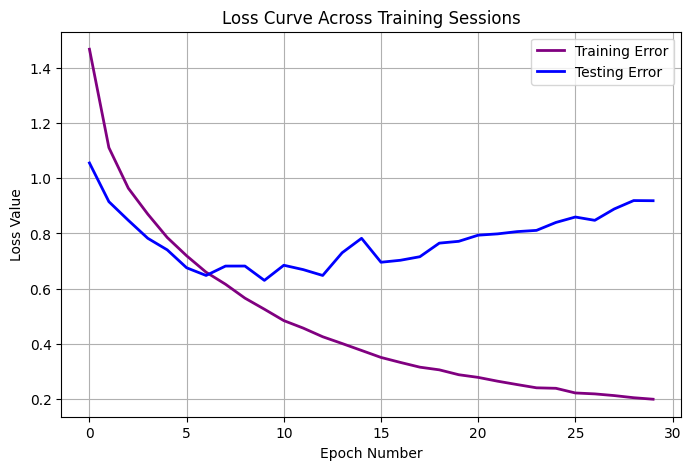

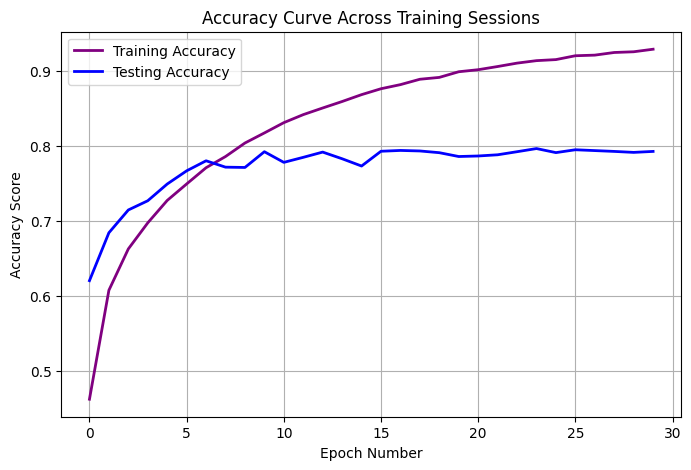

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

# Device Setup
compute_dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Active Device:", compute_dev)

# Transformations & Data Loaders
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4907, 0.4877, 0.4765],
        std=[0.2003, 0.1950, 0.2310]
    )
])

train_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=img_transform
)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=0
)

test_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=img_transform
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=False, num_workers=0
)

label_names = train_data.classes

# CNN model (reusing architecture)
class CIFAR_Model(nn.Module):
    def __init__(self):
        super(CIFAR_Model, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 32x32 -> 16x16 -> 8x8 -> 4x4
        self.fc_layer1 = nn.Linear(128 * 4 * 4, 256)
        self.fc_layer2 = nn.Linear(256, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, z):
        z = self.block1(z)
        z = self.block2(z)
        z = self.block3(z)
        z = z.view(z.size(0), -1)
        z = F.relu(self.fc_layer1(z))
        z = self.drop(z)
        z = self.fc_layer2(z)
        return z

cnn = CIFAR_Model().to(compute_dev)

# Loss & Optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters(), lr=0.0015)

# Training Phase
tr_losses = []
ts_losses = []
tr_accs = []
ts_accs = []

epochs = 30
time_start = time.time()

for ep in range(epochs):

    # ----- Training -----
    cnn.train()
    ep_loss = 0.0
    tr_correct = 0
    tr_total = 0

    for images, labels in train_loader:
        images = images.to(compute_dev)
        labels = labels.to(compute_dev)

        preds = cnn(images)
        err = loss_fn(preds, labels)

        opt.zero_grad()
        err.backward()
        opt.step()

        ep_loss += err.item()
        _, guess = torch.max(preds, 1)
        tr_total += labels.size(0)
        tr_correct += (guess == labels).sum().item()

    tr_losses.append(ep_loss / len(train_loader))
    tr_accs.append(tr_correct / tr_total)

    # ----- Testing -----
    cnn.eval()
    ts_loss = 0.0
    ts_correct = 0
    ts_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(compute_dev)
            labels = labels.to(compute_dev)

            out = cnn(images)
            loss_v = loss_fn(out, labels)

            ts_loss += loss_v.item()
            _, guess = torch.max(out, 1)
            ts_total += labels.size(0)
            ts_correct += (guess == labels).sum().item()

    ts_losses.append(ts_loss / len(test_loader))
    ts_accs.append(ts_correct / ts_total)

time_end = time.time()
total_runtime = time_end - time_start

# ----------------------------------------------------
# 6. Validation Data Table
# ----------------------------------------------------
print("\nEpoch-wise Evaluation Metrics")
print("-" * 55)
print(f"{'Epoch':>5} | {'Test Loss':>12} | {'Test Accuracy':>14}")
print("-" * 55)

for i, (ls, ac) in enumerate(zip(ts_losses, ts_accs), start=1):
    print(f"{i:5d} | {ls:12.4f} | {ac:14.4f}")

print("-" * 55)

# ----------------------------------------------------
# 7. Runtime Summary Table
# ----------------------------------------------------
print("\nRuntime Summary")
print("-" * 48)
print(f"{'Parameter':<25} | {'Value':>18}")
print("-" * 48)
print(f"{'Total Epochs':<25} | {epochs:18d}")
print(f"{'Total Time (seconds)':<25} | {total_runtime:18.2f}")
print(f"{'Time per Epoch (sec)':<25} | {total_runtime/epochs:18.2f}")
h = int(total_runtime // 3600)
m = int((total_runtime % 3600) // 60)
s = total_runtime % 60
print(f"{'Formatted Time (h:m:s)':<25} | {h:02d}:{m:02d}:{s:04.1f}")
print("-" * 48)

# Architecture Table
def show_architecture(model):
    print("\nModel Structure & Parameter Count")
    print("-" * 65)
    print(f"{'Layer Name':<40} | {'Params':>12}")
    print("-" * 65)

    total = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            n = param.numel()
            total += n
            print(f"{name:<40} | {n:12d}")

    print("-" * 65)
    print(f"{'Total Trainable Params':<40} | {total:12d}")
    print("-" * 65)

show_architecture(cnn)

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(tr_losses, label="Training Error", color="purple", linewidth=2)
plt.plot(ts_losses, label="Testing Error", color="blue", linewidth=2)
plt.xlabel("Epoch Number")
plt.ylabel("Loss Value")
plt.title("Loss Curve Across Training Sessions")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(tr_accs, label="Training Accuracy", color="purple", linewidth=2)
plt.plot(ts_accs, label="Testing Accuracy", color="blue", linewidth=2)
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Curve Across Training Sessions")
plt.legend()
plt.grid(True)
plt.show()
